# Clustering with Basic K-Means 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Goal 
Write functions to implement the basic k-means algorithm and apply those to a test dataset. 

## Load Data 


In [3]:
df_kmeans = pd.read_csv("https://gist.githubusercontent.com/TieJean/ff4dbd0022ab5e292db73d8b4910f551/raw/624db21e20faa92b79e5289ce4d9002e863b0d68/data_kmeans.csv")
df_kmeans.head()

,x,y
0,-0.731698,-0.874311
1,-0.547702,-0.580320
2,-0.762840,-0.885572
3,-0.340946,-0.810411
4,-0.749065,-0.399218


## Write function to return k random rows 

This function will accept two parameters: a data frame df_data, and an integer k, and returns the initial centroids for our k-means algorithm. The return values will be the indices of k random points from the dataframe. 

Using random_state = 42

In [4]:
def init_centroids( df_data, k ):
    return df_data.sample(n = k, random_state = 42).reset_index(drop=True)

In [6]:
# apply function to data to get initial centroids 
df_centroids = init_centroids( df_kmeans, 7 )
df_centroids

,x,y
0,-0.633437,0.488756
1,-0.597736,0.632194
2,-0.635867,0.166613
3,-0.539351,-0.875532
4,-0.588597,0.293062
5,-0.127985,-0.136639
6,0.342579,0.211717


## Write function to assign every row of data to a centroid 
This function will accept two parameters: a data frame, df_data, that represents our data to be clustered, and the data frame, df_centroids, which is of length k and contains the current centroids for our clusters.  It returns a series of the same length of df_data that contains the index of the closest centroid in df_centroid. 

Using Euclidean distance as the distance measure. 

In [7]:
def assign_to_centroid( df_data, df_centroids ):
    closest_idxs = []
        
    for i in range(len(df_data)):
        point = list(df_data.iloc[i].values)
        centroid_distances = []
        
        for j in range(len(df_centroids)):
            centroid = list(df_centroids.iloc[j].values)
            distSum = 0
            
            for k in range(len(centroid)):
                c = centroid[k]
                p = point[k]
                distSum += ((c - p)**2)
                
            distance = np.sqrt(distSum)
            centroid_distances.append(distance)
        
        idx_min = np.inf
        dist_min = np.inf

        for idx in range(len(df_centroids)):
            dist = centroid_distances[idx]
            if dist < dist_min:
                idx_min = idx
                dist_min = dist
        closest_idxs.append(idx_min)
    
    return pd.Series(closest_idxs)

In [8]:
# apply function to centroids to make assignments to centroids 
s_centroid_assignment = assign_to_centroid( df_kmeans, df_centroids )
s_centroid_assignment.value_counts()

6    126
1     94
3     71
5     58
0     53
2     26
4     22
dtype: int64

## Write function that recomputes centroids 

This function takes two parameters: the data frame, df_data containing the data being clustered, and a series of the same length that contains the label of the assigned centroid for every row in df_data, s_centroid_assignment. It will return a data frame containing the centroids (mean) value for each unique centroid. 

In [9]:
def compute_centroids( df_data, s_centroid_assignment ):
    temp_df = df_data.copy()
    temp_df['centroid_assignment'] = s_centroid_assignment
    
    k = s_centroid_assignment.nunique()
    new_centroids = []
    for idx in range(k):
        k_df = temp_df[temp_df['centroid_assignment'] == idx]
        xsMean = k_df['x'].mean()
        ysMean= k_df['y'].mean()
        new_centroids.append([xsMean, ysMean])
        
    xs = []
    ys = []
    for point in new_centroids:
        xs.append(point[0])
        ys.append(point[1])
    
    new_df = pd.DataFrame()
    new_df['x'] = xs
    new_df['y'] = ys
    
    return new_df

In [11]:
# apply function to data to get new centroids
df_new_centroids = compute_centroids( df_kmeans, s_centroid_assignment)
df_new_centroids

,x,y
0,-0.715983,0.500552
1,-0.721574,0.708343
2,-0.738268,-0.113830
3,-0.696694,-0.699028
4,-0.546913,0.321364
5,-0.102365,-0.188876
6,0.523364,0.238569


## Write function that compares two centroid data frames 

The stopping condition for our k-means is when our centroids have not moved since the last iteration. 

This function will take 2 centroid dataframes and return a boolean indicating if the centroids at each unique index are equal. 

In [12]:
def compare_centroids( df_centroid_a, df_centroid_b ):
    same = True
    for i in range(len(df_centroid_a)):
        series1 = df_centroid_a.iloc[i]
        series2 = df_centroid_b.iloc[i]
        compare = series1.equals(series2)
        if compare == False:
            same = False
    return same

In [13]:
# apply to centroid dataframes to check equality 
print(compare_centroids( df_new_centroids, df_centroids ))

False


## Write function that implements k-means via the previously written functions

This function takes a dataframe with values to cluster and the number of clusters to form (k). It returns a series of data of the same length as the original dataset that contains the cluster assignments. 

In [14]:
def k_means( df_data, k ):

    # initial clustering  
    centroids = init_centroids(df_data, k)
    assignments = assign_to_centroid(df_data, centroids)
    newCentroids = compute_centroids(df_data, assignments)
    
    # continue until centroids are equal
    while compare_centroids(centroids, newCentroids) == False:
        centroids = newCentroids
        assignments = assign_to_centroid(df_data, newCentroids)
        newCentroids = compute_centroids(df_data, assignments)
    
    return assignments

In [15]:
# apply k_means with k = 5 to test data
s_cluster_assignment = k_means( df_kmeans, 5)
s_cluster_assignment.value_counts()

0    178
3     89
2     74
4     63
1     46
dtype: int64

## Plot the results 

Plot the points in the original dataset using the generated clusters. 

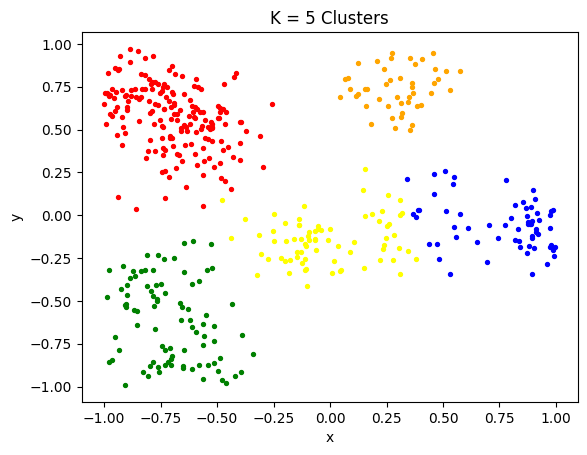

In [16]:
colors = ['red', 'orange', 'yellow', 'green', 'blue']
temp_df = df_kmeans.copy()
temp_df['cluster'] = s_cluster_assignment

for i in range(5):
    x = temp_df[temp_df['cluster'] == i]['x']
    y = temp_df[temp_df['cluster'] == i]['y']
    plt.scatter(x, y, s = 8, color = colors[i])

plt.xlabel('x')
plt.ylabel('y')
plt.title('K = 5 Clusters');